<h5> Description of dataset and task

The Entertainment Software Rating Board(ESRB) ratings provide information about the contents of a game so parents and consumers can make informed choices about which game are right for the family (https://www.esrb.org/#rating-categories).

The *Video Games Rating by 'ESRB'* is a dataset composed of **1895** games with 34 of *ESRB Rating Content* along with its name and console exclusivity as features for each game. 
<p> This Notebook aims to create and experiment models capable of classifying games into their proper *ESRB Rating*. </p>


*ESRB Rating Content* (32) refers to the following:
- Alcohol Reference : Reference to and/or images of alcoholic beverages.
- Animated Blood : Discolored and/or unrealistic depictions of blood.
- Blood : Depictions of blood.
- Blood and Gore : 	Depictions of blood or the mutilation of body parts.
- Cartoon Violence : Violent actions involving cartoon-like situations and characters. May include violence where a character is unharmed after the action has been inflicted.
- Crude Humor : Depictions or dialogue involving vulgar antics, including "bathroom" humor.
- Drug Reference : 	Reference to and/or images of illegal drugs.
- Fantasy Violence : Violent actions of a fantasy nature, involving human or non-human characters in situations easily distinguishable from real life.
- Intense Violence : Graphic and realistic-looking depictions of physical conflict. May involve extreme and/or realistic blood, gore, weapons, and depictions of human injury and death.
- Language : Moderate use of profanity.
- Lyrics : References to profanity, sexuality, violence, alcohol, or drug use in music.
- Mature Humor : Depictions or dialogue involving "adult" humor, including sexual references.
- Mild Blood : 	Some blood.
- Mild Cartoon Violence : Some violent actions involving cartoon.
- Mild Fantasy Violence : Some violent actions of a fantasy nature.
- Mild Language : 	Mild to moderate use of profanity.
- Mild Lyrics : Mild References to profanity, sexuality, violence, alcohol, or drug use in music.
- Mild Suggestive Themes : 	some provocative references or materials
- Mild Violence : 	Some scenes involving aggressive conflict.
- No Descriptors : 	No content descriptors
- Nudity : 	Graphic or prolonged depictions of nudity.
- Partial Nudity : Brief and/or mild depictions of nudity.
- Sexual Content : Non-explicit depictions of sexual behavior, possibly including partial nudity.
- Sexual Themes : 	References to sex or sexuality.
- Simulated Gambling : Player can gamble without betting or wagering real cash or currency.
- Strong Language : Explicit and/or frequent use of profanity.
- Strong Sexual Content : 	Explicit and/or frequent depictions of sexual behavior, possibly including nudity.
- Suggestive Themes : 	Provocative references or materials.
- Use of Alcohol :	The consumption of alcoholic beverages.
- Use of Drugs and Alcohol : The consumption of alcoholic and drugs beverages.
- Violence : Scenes involving aggressive conflict. May contain bloodless dismemberment.

*ESRB Rating* refers to the following:
- E : Everyone
- ET : Everyone 10+
- T : teen
- M : Mature

Import revelant libraries.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.optim as optim
import torch.nn as nn
import torch

from data_loader import DataLoader

from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import SGDClassifier

import optuna
from optuna.trial import TrialState

%matplotlib inline

%load_ext autoreload
%autoreload 2

<h5>  Data Preprocessing

In [2]:
from jupyterthemes import jtplot
jtplot.style()

In [3]:
df_esrb = pd.read_csv("Video_Games_esrb_rating.csv")
df_esrb.head(5)

,title,console,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,...,sexual_content,sexual_themes,simulated_gambling,strong_janguage,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence,esrb_rating
0,Monster Jam Steel Titans 2,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,E
1,Subnautica: Below Zero,1,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,ET
2,NIER REPLICANT VER.1.22474487139…,1,0,0,1,0,0,0,0,0,...,0,0,0,1,0,1,0,0,0,M
3,Jamestown+,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,ET
4,Neptunia Virtual Stars,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,1,0,0,0,T


In [4]:
df_esrb.columns

Index(['title', 'console', 'alcohol_reference', 'animated_blood', 'blood',
       'blood_and_gore', 'cartoon_violence', 'crude_humor', 'drug_reference',
       'fantasy_violence', 'intense_violence', 'language', 'lyrics',
       'mature_humor', 'mild_blood', 'mild_cartoon_violence',
       'mild_fantasy_violence', 'mild_language', 'mild_lyrics',
       'mild_suggestive_themes', 'mild_violence', 'no_descriptors', 'nudity',
       'partial_nudity', 'sexual_content', 'sexual_themes',
       'simulated_gambling', 'strong_janguage', 'strong_sexual_content',
       'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol',
       'violence', 'esrb_rating'],
      dtype='object')

`strong_janguage` is a clear typo of `strong_language` so we replace that.

In [5]:
df_esrb = df_esrb.rename(columns={"strong_janguage" : "strong_language"})

Let's display the general `info` of the dataset

In [6]:
df_esrb.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1895 entries, 0 to 1894
Data columns (total 34 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   title                     1895 non-null   object
 1   console                   1895 non-null   int64 
 2   alcohol_reference         1895 non-null   int64 
 3   animated_blood            1895 non-null   int64 
 4   blood                     1895 non-null   int64 
 5   blood_and_gore            1895 non-null   int64 
 6   cartoon_violence          1895 non-null   int64 
 7   crude_humor               1895 non-null   int64 
 8   drug_reference            1895 non-null   int64 
 9   fantasy_violence          1895 non-null   int64 
 10  intense_violence          1895 non-null   int64 
 11  language                  1895 non-null   int64 
 12  lyrics                    1895 non-null   int64 
 13  mature_humor              1895 non-null   int64 
 14  mild_blood              

Since theres no `null` values in the dataset, we can proceed

In [7]:
df_no_desriptors = df_esrb[df_esrb['no_descriptors'] == 1].sum(axis=1) 
df_no_desriptors.shape[0]

322

Since `no_descriptors` means that none of the _ESRB Content_ is found in the game, we need to check fix games that might contradict that.

In [8]:
(df_no_desriptors>1).sum()
# print(df_no_desriptors)

205

In [9]:
idx = df_no_desriptors[df_no_desriptors>1].index
# df_esrb.iloc[idx].loc['no_descriptors'] = 0

df_esrb.loc[idx,'no_descriptors'] = 0

df_esrb.iloc[idx]['no_descriptors']

0       0
5       0
27      0
30      0
31      0
       ..
1867    0
1872    0
1875    0
1877    0
1894    0
Name: no_descriptors, Length: 205, dtype: int64

Seems like there are 205 entries have the `no_descriptors` flagged wrong.

<h5> Exploratory data analysis

Which _ESRB Rating_ is most prominent?

<BarContainer object of 4 artists>

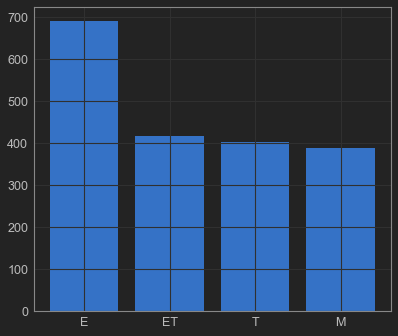

In [10]:
ratings = ["E" , "ET" , "T", "M"]

counts = df_esrb['esrb_rating'].value_counts()

plt.bar(ratings, counts)

([<matplotlib.patches.Wedge at 0x1ae8a6df730>,
 [Text(0.4571073038439642, 1.000526317880995, 'E'),
  Text(-1.0846159132817186, 0.18332572284342297, 'ET'),
  Text(-0.40849519606388207, -1.021338178466237, 'T'),
  Text(0.8812655227327117, -0.6583092574486862, 'M')],
 [Text(0.24933125664216227, 0.5457416279350882, '36.36'),
  Text(-0.5916086799718464, 0.09999584882368524, '21.95'),
  Text(-0.2228155614893902, -0.5570935518906747, '21.27'),
  Text(0.48069028512693357, -0.3590777767901924, '20.42')])

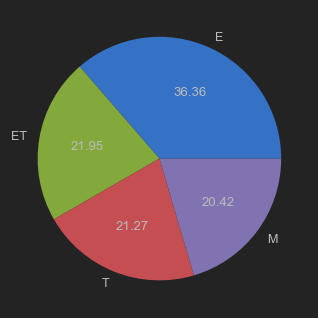

In [11]:
plt.pie(counts, labels= ratings, autopct='%.2f')

The _ESRB Rating_ **T** appears to be the most prominent rating.

Next, lets find the most prominent `ESRB Rating Content`

In [12]:
df_esrb[df_esrb['no_descriptors'] == 1]["esrb_rating"].value_counts()

E    117
Name: esrb_rating, dtype: int64

<AxesSubplot:>

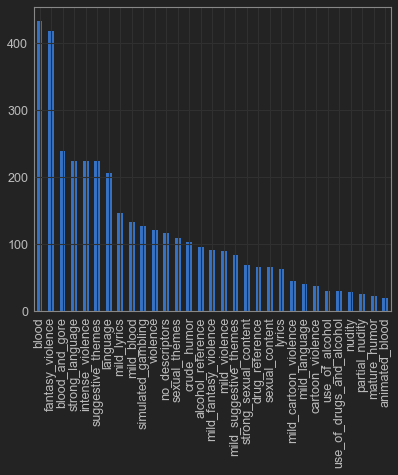

In [13]:
df_dropped = df_esrb.drop(['title','console','esrb_rating'], axis = 1)
df_count_content = df_dropped.sum(axis=0)
df_count_content.sort_values(axis=0, ascending=False, inplace=True)
df_count_content.plot.bar(x="Content", y="Count", )

We can visibly see that the _ESRB Content_ **blood** is the most prominent while **fantasy_violence** comes close in second.

Let us check the correlelations of each _ESRB Content_

In [14]:
df_esrb.columns

Index(['title', 'console', 'alcohol_reference', 'animated_blood', 'blood',
       'blood_and_gore', 'cartoon_violence', 'crude_humor', 'drug_reference',
       'fantasy_violence', 'intense_violence', 'language', 'lyrics',
       'mature_humor', 'mild_blood', 'mild_cartoon_violence',
       'mild_fantasy_violence', 'mild_language', 'mild_lyrics',
       'mild_suggestive_themes', 'mild_violence', 'no_descriptors', 'nudity',
       'partial_nudity', 'sexual_content', 'sexual_themes',
       'simulated_gambling', 'strong_language', 'strong_sexual_content',
       'suggestive_themes', 'use_of_alcohol', 'use_of_drugs_and_alcohol',
       'violence', 'esrb_rating'],
      dtype='object')

In [15]:
correlation = df_dropped.corr()
correlation.style.background_gradient(cmap="coolwarm", axis=None).set_precision(2)

,alcohol_reference,animated_blood,blood,blood_and_gore,cartoon_violence,crude_humor,drug_reference,fantasy_violence,intense_violence,language,lyrics,mature_humor,mild_blood,mild_cartoon_violence,mild_fantasy_violence,mild_language,mild_lyrics,mild_suggestive_themes,mild_violence,no_descriptors,nudity,partial_nudity,sexual_content,sexual_themes,simulated_gambling,strong_language,strong_sexual_content,suggestive_themes,use_of_alcohol,use_of_drugs_and_alcohol,violence
alcohol_reference,1.00,0.00,-0.08,-0.04,0.05,-0.00,0.01,-0.08,0.15,-0.03,0.08,0.11,0.02,0.12,-0.04,0.03,0.01,0.22,0.10,-0.06,0.03,-0.01,-0.04,-0.03,-0.00,-0.08,0.01,-0.00,0.16,-0.03,-0.04
animated_blood,0.00,1.00,-0.05,-0.04,-0.01,-0.00,0.15,-0.03,0.09,0.05,-0.02,-0.01,0.03,-0.02,-0.02,-0.01,-0.03,0.06,-0.02,-0.03,-0.01,-0.01,-0.02,-0.02,-0.03,-0.02,-0.02,-0.04,0.07,0.03,0.02
blood,-0.08,-0.05,1.00,-0.21,-0.07,-0.08,-0.04,-0.17,0.09,0.03,0.06,0.12,-0.13,-0.07,-0.12,-0.08,-0.01,-0.00,-0.08,-0.14,-0.02,0.05,0.08,0.07,0.11,0.29,-0.04,0.09,-0.04,-0.02,0.01
blood_and_gore,-0.04,-0.04,-0.21,1.00,-0.04,-0.03,0.12,-0.17,0.29,0.10,0.05,-0.03,-0.07,-0.06,-0.08,-0.06,-0.09,-0.04,-0.05,-0.10,0.12,-0.00,0.14,0.12,0.01,0.22,0.34,-0.03,-0.01,0.05,0.06
cartoon_violence,0.05,-0.01,-0.07,-0.04,1.00,-0.02,0.01,-0.08,-0.05,-0.05,0.04,-0.02,-0.04,0.00,-0.01,-0.02,0.00,0.08,0.02,-0.04,-0.02,-0.02,-0.03,0.03,-0.02,-0.05,-0.03,0.01,0.04,0.01,-0.04
crude_humor,-0.00,-0.00,-0.08,-0.03,-0.02,1.00,-0.05,-0.08,0.09,-0.06,0.03,0.02,-0.06,0.10,-0.02,0.01,-0.06,0.08,-0.03,-0.06,0.01,0.01,-0.03,-0.03,0.32,-0.07,0.02,-0.03,-0.01,-0.03,-0.01
drug_reference,0.01,0.15,-0.04,0.12,0.01,-0.05,1.00,-0.10,0.02,0.17,0.05,0.06,0.14,-0.01,-0.03,-0.03,0.01,0.02,0.01,-0.05,0.02,0.05,0.03,0.09,0.06,0.16,0.07,0.04,-0.02,-0.02,-0.00
fantasy_violence,-0.08,-0.03,-0.17,-0.17,-0.08,-0.08,-0.10,1.00,-0.17,-0.00,-0.03,0.06,0.23,-0.07,-0.11,-0.08,0.10,0.03,-0.01,-0.14,-0.01,-0.05,-0.04,-0.04,-0.04,-0.07,-0.05,0.08,0.00,0.00,-0.09
intense_violence,0.15,0.09,0.09,0.29,-0.05,0.09,0.02,-0.17,1.00,-0.11,0.07,0.05,-0.06,0.09,-0.07,-0.05,-0.11,0.17,0.01,-0.09,0.09,-0.04,0.00,0.02,0.01,0.10,0.39,-0.01,0.06,0.01,-0.01
language,-0.03,0.05,0.03,0.10,-0.05,-0.06,0.17,-0.00,-0.11,1.00,-0.04,-0.01,0.04,-0.05,-0.05,-0.02,-0.10,-0.08,-0.01,-0.09,0.08,0.02,-0.03,0.09,0.04,0.02,-0.01,0.08,-0.00,0.02,-0.02


It seems that generally the correlation between each *ESRB Content* is very weak with the strongest correlation of *0.39* between .

<h5> Model Training

Since the dataset already provided a separate test dataset, we wont be needing to split the training dataset. We will only need to create a validation dataset

In [16]:
accuracy = [] # for storing accuraries
label_encoder = preprocessing.LabelEncoder()

In [17]:
y = label_encoder.fit_transform(df_esrb[['esrb_rating']].values.ravel())
print(y.shape)
print(df_dropped.shape)

(1895,)
(1895, 31)


In [18]:
print(y)

[0 1 2 ... 0 3 0]


In [19]:
X = df_dropped.values

In [20]:
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.20, stratify = y, random_state = 42)

In [21]:
df_test = pd.read_csv("test_esrb.csv")
X_test = df_test.drop(['title','console','esrb_rating'], axis = 1).values
y_test = label_encoder.fit_transform(df_test[['esrb_rating']].values.ravel())
X_test.shape

(500, 31)

Convert pandas to tensors

In [22]:
X_train = torch.Tensor(X_train)
y_train = torch.Tensor(y_train)

X_test = torch.Tensor(X_test)
y_test = torch.Tensor(y_test)

X_val = torch.Tensor(X_val)
y_val = torch.Tensor(y_val)

In [23]:
y_train

tensor([2., 3., 1.,  ..., 2., 0., 1.])

In [24]:
label_mapping = dict(zip(label_encoder.classes_, label_encoder.transform(label_encoder.classes_)))

<h5> Neural Network

In [25]:
# 31 -> 4
network = nn.Sequential(
    nn.Linear(31,12),
    nn.ELU(inplace=True),
    nn.Linear(12,6),
    nn.ELU(inplace=True),
    nn.Linear(6,4),
    nn.LogSoftmax(dim = 0)
)
network

Sequential(
  (0): Linear(in_features=31, out_features=12, bias=True)
  (1): ELU(alpha=1.0, inplace=True)
  (2): Linear(in_features=12, out_features=6, bias=True)
  (3): ELU(alpha=1.0, inplace=True)
  (4): Linear(in_features=6, out_features=4, bias=True)
  (5): LogSoftmax(dim=0)
)

In [26]:
data_loader = DataLoader(X_train,y_train,48)

In [27]:
loss_fn = nn.CrossEntropyLoss()

![epochs.png](epochs.png)

We trained the model with an epoch of 1500 to see what number of epochs is good for efficiency and accuracy. About 200 is where the "elbow" is seen but we decided around 350 to chase for a slight improvement in accuracy.

In [28]:
def objective(trial):
    e = 0
    max_epochs = 350
    is_converged = False
    previous_loss = 0
    losses = []

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=False)
    optimizer = getattr(optim, optimizer_name)(network.parameters(), lr=lr)

    while e < max_epochs and is_converged is not True:
    
        current_epoch_loss = 0
        
        X_batch, y_batch = data_loader.get_batch()
        
        # For each batch
        for X, y in zip(X_batch, y_batch):
            X = torch.Tensor(X)
            y = torch.Tensor(y).to(torch.long)
            
            optimizer.zero_grad()
            
            s = network.forward(X)
            
            loss = loss_fn(s,y)
            
            loss.backward()
            
            optimizer.step()
            
            current_epoch_loss += loss.item()
        
        average_loss = current_epoch_loss / len(X_batch)
        losses.append(average_loss)
        
        # Display the average loss per epoch
        # print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
        
        if abs(previous_loss - loss) < 0.0000005:
            is_converged = True
        else:
            previous_loss = loss
            e += 1
    # get accu
    network.eval()

    with torch.no_grad():
        output = network.forward(X_val)
        pred = output.argmax(dim=1, keepdim=True)
        # num_correct = torch.sum(pred == y_val)
    
    accuracy = accuracy_score(pred,y_val)*100.0
    trial.report(accuracy, e)

    return accuracy


        

    

In [29]:
# study = optuna.create_study(direction = 'maximize')
# study.optimize(objective, n_trials=100)

# print("  Number of finished trials: ", len(study.trials))

# print("Best trial:")
# trial = study.best_trial

# print("  Value: ", trial.value)

# print("  Params: ")
# for key, value in trial.params.items():
#     print("    {}: {}".format(key, value))

In [30]:
# study.best_trial

<font size="1"> FrozenTrial(number=1, values=[85.4881266490765], datetime_start=datetime.datetime(2022, 6, 30, 20, 25, 36, 105827), datetime_complete=datetime.datetime(2022, 6, 30, 20, 25, 47, 442350), params={'optimizer': 'RMSprop', 'lr': 0.009992566127730968}, distributions={'optimizer': CategoricalDistribution(choices=('Adam', 'RMSprop')), 'lr': UniformDistribution(high=0.01, low=1e-05)}, user_attrs={}, system_attrs={}, intermediate_values={350: 85.4881266490765}, trial_id=1, state=TrialState.COMPLETE, value=None)

Using optuna to optimize the hyperparameters (learning rate and optimizer), it came to a conclusion that Using RMSprop with a learning rate of 0.009992566127730968 resulted in the best validation accuracy, 85.4881266490765%.

In [31]:
e = 0
max_epochs = 350
is_converged = False
previous_loss = 0
losses = []

lr = 0.009992566127730968
optimizer = optim.RMSprop(network.parameters(), lr=lr)

while e < max_epochs and is_converged is not True:

    current_epoch_loss = 0
    
    X_batch, y_batch = data_loader.get_batch()
    
    # For each batch
    for X, y in zip(X_batch, y_batch):
        X = torch.Tensor(X)
        y = torch.Tensor(y).to(torch.long)
        
        optimizer.zero_grad()
        
        s = network.forward(X)
        
        loss = loss_fn(s,y)
        
        loss.backward()
        
        optimizer.step()
        
        current_epoch_loss += loss.item()
    
    average_loss = current_epoch_loss / len(X_batch)
    losses.append(average_loss)
    
    # Display the average loss per epoch
    print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
    
    if abs(previous_loss - loss) < 0.0000005:
        is_converged = True
    else:
        previous_loss = loss
        e += 1


Epoch: 1 	Loss: 0.630075
Epoch: 2 	Loss: 0.388469
Epoch: 3 	Loss: 0.353211
Epoch: 4 	Loss: 0.346960
Epoch: 5 	Loss: 0.342963
Epoch: 6 	Loss: 0.341983
Epoch: 7 	Loss: 0.335887
Epoch: 8 	Loss: 0.325670
Epoch: 9 	Loss: 0.325056
Epoch: 10 	Loss: 0.322027
Epoch: 11 	Loss: 0.314302
Epoch: 12 	Loss: 0.319137
Epoch: 13 	Loss: 0.314122
Epoch: 14 	Loss: 0.313123
Epoch: 15 	Loss: 0.312430
Epoch: 16 	Loss: 0.315453
Epoch: 17 	Loss: 0.306380
Epoch: 18 	Loss: 0.305680
Epoch: 19 	Loss: 0.304923
Epoch: 20 	Loss: 0.303256
Epoch: 21 	Loss: 0.305890
Epoch: 22 	Loss: 0.303843
Epoch: 23 	Loss: 0.296420
Epoch: 24 	Loss: 0.306170
Epoch: 25 	Loss: 0.300494
Epoch: 26 	Loss: 0.290041
Epoch: 27 	Loss: 0.304464
Epoch: 28 	Loss: 0.296775
Epoch: 29 	Loss: 0.293992
Epoch: 30 	Loss: 0.297818
Epoch: 31 	Loss: 0.296866
Epoch: 32 	Loss: 0.289188
Epoch: 33 	Loss: 0.281879
Epoch: 34 	Loss: 0.290335
Epoch: 35 	Loss: 0.287076
Epoch: 36 	Loss: 0.283593
Epoch: 37 	Loss: 0.282336
Epoch: 38 	Loss: 0.280776
Epoch: 39 	Loss: 0.27

In [32]:
network.eval()

with torch.no_grad():
    output = network.forward(X_test)
    pred = output.argmax(dim=1, keepdim=True)
nn_accuracy = accuracy_score(pred,y_test)*100.0
accuracy.append(('Neural Network',nn_accuracy))
confusion_mat = confusion_matrix(pred,y_test)
classification_rep = classification_report(pred,y_test,target_names=label_mapping.keys(),digits=4)

In [33]:
def test_trial(trial):
    e = 0
    max_epochs = 350
    is_converged = False
    previous_loss = 0
    losses = []

    optimizer_name = trial.suggest_categorical("optimizer", ["Adam", "RMSprop"])
    lr = trial.suggest_float("lr", 1e-5, 1e-2, log=False)
    optimizer = getattr(optim, optimizer_name)(network.parameters(), lr=lr)

    while e < max_epochs and is_converged is not True:
    
        current_epoch_loss = 0
        
        X_batch, y_batch = data_loader.get_batch()
        
        # For each batch
        for X, y in zip(X_batch, y_batch):
            X = torch.Tensor(X)
            y = torch.Tensor(y).to(torch.long)
            
            optimizer.zero_grad()
            
            s = network.forward(X)
            
            loss = loss_fn(s,y)
            
            loss.backward()
            
            optimizer.step()
            
            current_epoch_loss += loss.item()
        
        average_loss = current_epoch_loss / len(X_batch)
        losses.append(average_loss)
        
        # Display the average loss per epoch
        # print('Epoch:', e + 1, '\tLoss: {:.6f}'.format(average_loss))
        
        if abs(previous_loss - loss) < 0.0000005:
            is_converged = True
        else:
            previous_loss = loss
            e += 1
    # get accu
    network.eval()

    with torch.no_grad():
        output = network.forward(X_test)
        pred = output.argmax(dim=1, keepdim=True)
        # num_correct = torch.sum(pred == y_val)
    
    accuracy = accuracy_score(pred,y_test)*100.0
    trial.report(accuracy, e)

    return accuracy, confusion_matrix(pred,y_test), classification_report(pred,y_test,target_names=label_mapping.keys(),digits=4)

In [34]:
# study.best_trial

In [35]:
# accuracy , confusion_mat, classification_rep = test_trial(study.best_trial)
disp = ConfusionMatrixDisplay(confusion_mat, display_labels = label_mapping)


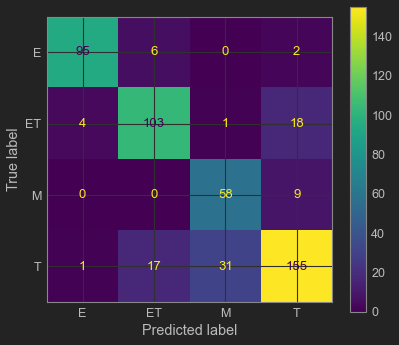

              precision    recall  f1-score   support

           E     0.9500    0.9223    0.9360       103
          ET     0.8175    0.8175    0.8175       126
           M     0.6444    0.8657    0.7389        67
           T     0.8424    0.7598    0.7990       204

    accuracy                         0.8220       500
   macro avg     0.8136    0.8413    0.8228       500
weighted avg     0.8318    0.8220    0.8238       500

The accuracy of the neural network model is :  82.19999999999999 %


In [36]:
disp.plot()
plt.show()
print(classification_rep)
print("The accuracy of the neural network model is : ",nn_accuracy,"%")

The model struggled in predicting some of the "T" rated games as "M". 

<h5> Decision Tree 

In [37]:

dtc = DecisionTreeClassifier(random_state=42)

In [38]:
dtc.fit(X_train, y_train)
predictions_train = dtc.predict(X_train)

In [39]:

def compute_accuracy(predictions, actual):
    # write code here
    return accuracy_score(actual, predictions) * 100

In [40]:
print("Training accuracy: ", compute_accuracy(y_train, predictions_train),"%")

Training accuracy:  91.88654353562006 %


In [41]:
predictions = dtc.predict(X_test)
dtc_accuracy = compute_accuracy(y_test, predictions)
accuracy.append(("Decision Tree",dtc_accuracy))
print("Testing accuracy: ", dtc_accuracy,"%")

Testing accuracy:  83.0 %


<h5> Logistic Regression

Instantiate SGDClassifier to create a Logistic regression model.

In [42]:
# log_reg_model = SGDClassifier(loss='log_loss', random_state=1, verbose=1)
log_reg_model = SGDClassifier(loss='log', random_state=1, verbose=1)
max_epochs = 350

In [43]:
log_reg_model.fit(X_train, y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


-- Epoch 1
Norm: 35.44, NNZs: 31, Bias: 4.983405, T: 1516, Avg. loss: 0.190804
Total training time: 0.00 seconds.
-- Epoch 2
Norm: 28.14, NNZs: 31, Bias: 3.101995, T: 3032, Avg. loss: 0.096965
Total training time: 0.00 seconds.
-- Epoch 3
Norm: 25.11, NNZs: 31, Bias: 3.253871, T: 4548, Avg. loss: 0.075039
Total training time: 0.00 seconds.
-- Epoch 4
Norm: 23.62, NNZs: 31, Bias: 4.033325, T: 6064, Avg. loss: 0.065756
Total training time: 0.00 seconds.
-- Epoch 5
Norm: 23.07, NNZs: 31, Bias: 2.349643, T: 7580, Avg. loss: 0.066546
Total training time: 0.00 seconds.
-- Epoch 6
Norm: 22.75, NNZs: 31, Bias: 1.520802, T: 9096, Avg. loss: 0.063354
Total training time: 0.00 seconds.
-- Epoch 7
Norm: 22.50, NNZs: 31, Bias: 2.960721, T: 10612, Avg. loss: 0.062394
Total training time: 0.00 seconds.
-- Epoch 8
Norm: 22.31, NNZs: 31, Bias: 2.731014, T: 12128, Avg. loss: 0.060268
Total training time: 0.01 seconds.
-- Epoch 9
Norm: 22.31, NNZs: 31, Bias: 1.989293, T: 13644, Avg. loss: 0.061052
Total 

[Parallel(n_jobs=1)]: Done   4 out of   4 | elapsed:    1.0s finished


SGDClassifier(loss='log', random_state=1, verbose=1)

In [44]:
data_loader = DataLoader(X_train, y_train, 48)

Train our model.

In [45]:
# from sklearn.metrics import log_loss

# e = 0
# is_converged = False
# previous_loss = 0
# labels = np.unique(y_train)

# # For each epoch
# while e < max_epochs and is_converged is not True:
    
#     loss = 0
    
#     X_batch, y_batch = data_loader.get_batch()
    
#     # For each batch
#     for X, y in zip(X_batch, y_batch):
        
#         log_reg_model.partial_fit(X, y, classes = labels)
        
#         # Compute the loss
#         y_pred = log_reg_model.predict_proba(X_train)
#         loss += log_loss(y_train, y_pred)
        
#     # Display the average loss per epoch
#     # print('Epoch:', e + 1, '\tLoss:', (loss / len(X_batch)))
    
#     if abs(previous_loss - loss) < 0.05:
#         is_converged = True
#     else:
#         previous_loss = loss
#         e += 1

Get the prediction results on the test data.

In [46]:
predictions = log_reg_model.predict(X_test)

Compute for accuracy.

In [47]:
log_reg_accuracy = compute_accuracy(predictions, y_test)
accuracy.append(("Logistic Regression",log_reg_accuracy))
print("Testing accuracy: ", log_reg_accuracy, "%")

Testing accuracy:  80.60000000000001 %


Now that we have done an initial run on our three models, we will choose the best performing model and tune it.

In [48]:
print(accuracy)

[('Neural Network', 82.19999999999999), ('Decision Tree', 83.0), ('Logistic Regression', 80.60000000000001)]


<h5> Model Selection and hyperparameter tuning

In [49]:
unique, counts = np.unique(y_train, return_counts=True)
print("Training data label counts:")
print(np.array([unique, counts]))

Training data label counts:
[[  0.   1.   2.   3.]
 [333. 322. 310. 551.]]


In [50]:
ratings = np.array(unique)

In [51]:
dtc = DecisionTreeClassifier()

In [52]:
hyperparameters = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [ 5, 10, 20, 30],
        'min_samples_split': [2, 4, 6, 10, 15, 20],
        'max_leaf_nodes': [3, 5, 10, 20, 50, 100],
    }
]

Create  `RandomizedSearchCV` object

In [53]:
rsc_esrb = RandomizedSearchCV(dtc, n_iter=50, param_distributions=hyperparameters,cv=5,random_state=42)

In [54]:
rsc_esrb.fit(X_train, y_train)

RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=50,
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [5, 10, 20, 30],
                                         'max_leaf_nodes': [3, 5, 10, 20, 50,
                                                            100],
                                         'min_samples_split': [2, 4, 6, 10, 15,
                                                               20]}],
                   random_state=42)

Get the best parameters found from hyperparameter search

In [55]:
pd.set_option('display.max_colwidth', None)

rsc_results = pd.DataFrame(rsc_esrb.cv_results_)
rsc_results

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_min_samples_split,param_max_leaf_nodes,param_max_depth,param_criterion,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,0.006937,8.535793e-03,0.000391,4.785915e-04,10,5,10,gini,"{'min_samples_split': 10, 'max_leaf_nodes': 5, 'max_depth': 10, 'criterion': 'gini'}",0.674342,0.646865,0.669967,0.669967,0.699670,0.672162,0.016799,27
1,0.003710,2.084920e-03,0.001368,7.815362e-04,4,10,5,entropy,"{'min_samples_split': 4, 'max_leaf_nodes': 10, 'max_depth': 5, 'criterion': 'entropy'}",0.690789,0.656766,0.676568,0.653465,0.709571,0.677432,0.021041,19
2,0.002148,3.910073e-04,0.000586,4.784940e-04,15,3,30,entropy,"{'min_samples_split': 15, 'max_leaf_nodes': 3, 'max_depth': 30, 'criterion': 'entropy'}",0.516447,0.554455,0.557756,0.554455,0.567657,0.550154,0.017534,37
3,0.004101,2.343587e-03,0.000390,4.779499e-04,2,5,10,gini,"{'min_samples_split': 2, 'max_leaf_nodes': 5, 'max_depth': 10, 'criterion': 'gini'}",0.674342,0.646865,0.669967,0.669967,0.699670,0.672162,0.016799,27
4,0.002734,3.906499e-04,0.000586,4.784552e-04,4,3,10,entropy,"{'min_samples_split': 4, 'max_leaf_nodes': 3, 'max_depth': 10, 'criterion': 'entropy'}",0.516447,0.554455,0.557756,0.554455,0.567657,0.550154,0.017534,37
5,0.002930,1.068770e-03,0.000976,6.169540e-04,10,5,5,gini,"{'min_samples_split': 10, 'max_leaf_nodes': 5, 'max_depth': 5, 'criterion': 'gini'}",0.674342,0.646865,0.669967,0.669967,0.699670,0.672162,0.016799,27
6,0.002734,7.311111e-04,0.000391,4.783576e-04,15,5,10,gini,"{'min_samples_split': 15, 'max_leaf_nodes': 5, 'max_depth': 10, 'criterion': 'gini'}",0.674342,0.646865,0.669967,0.669967,0.699670,0.672162,0.016799,27
7,0.003122,7.326911e-04,0.000621,5.107096e-04,15,50,5,entropy,"{'min_samples_split': 15, 'max_leaf_nodes': 50, 'max_depth': 5, 'criterion': 'entropy'}",0.684211,0.653465,0.679868,0.656766,0.706271,0.676116,0.019372,24
8,0.001758,7.305251e-04,0.000586,4.786111e-04,20,3,20,gini,"{'min_samples_split': 20, 'max_leaf_nodes': 3, 'max_depth': 20, 'criterion': 'gini'}",0.516447,0.468647,0.488449,0.554455,0.475248,0.500649,0.031505,45
9,0.003516,1.586896e-03,0.000781,3.906015e-04,10,10,10,entropy,"{'min_samples_split': 10, 'max_leaf_nodes': 10, 'max_depth': 10, 'criterion': 'entropy'}",0.723684,0.745875,0.735974,0.768977,0.775578,0.750017,0.019599,14


In [56]:
rsc_esrb.best_params_

{'min_samples_split': 6,
 'max_leaf_nodes': 100,
 'max_depth': 30,
 'criterion': 'gini'}

Get the  best estimator index to in order to get the entry of the best performing model.

In [57]:
best_index = rsc_esrb.best_index_
best_index

26

In [58]:
rsc_results.loc[best_index]

mean_fit_time                                                                                            0.00548
std_fit_time                                                                                            0.001053
mean_score_time                                                                                         0.000973
std_score_time                                                                                          0.000618
param_min_samples_split                                                                                        6
param_max_leaf_nodes                                                                                         100
param_max_depth                                                                                               30
param_criterion                                                                                             gini
params                     {'min_samples_split': 6, 'max_leaf_nodes': 100, 'max_depth': 30, 'cri

Get the best estimator

In [59]:
rsc_esrb.best_estimator_

DecisionTreeClassifier(max_depth=30, max_leaf_nodes=100, min_samples_split=6)

In [60]:
dtc = rsc_esrb.best_estimator_
dtc.fit(X_train,y_train)

DecisionTreeClassifier(max_depth=30, max_leaf_nodes=100, min_samples_split=6)

In [61]:
predictions = dtc.predict(X_test)
print("Test accuracy is : ", compute_accuracy(predictions, y_test), "%")

Test accuracy is :  83.39999999999999 %


In [62]:
print(classification_report(y_test, predictions,target_names=label_mapping.keys(),digits=4))


              precision    recall  f1-score   support

           E     0.9223    0.9500    0.9360       100
          ET     0.7971    0.8730    0.8333       126
           M     0.8533    0.7111    0.7758        90
           T     0.8043    0.8043    0.8043       184

    accuracy                         0.8340       500
   macro avg     0.8443    0.8346    0.8373       500
weighted avg     0.8349    0.8340    0.8328       500



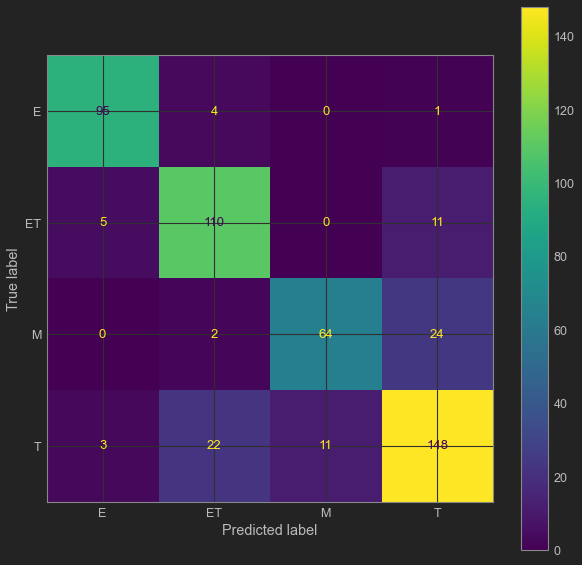

In [63]:
cm = confusion_matrix(y_test, predictions, labels=ratings)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax)

Lets try removing the 5 least important features

In [64]:
importances = dtc.feature_importances_

In [65]:

df_importances = pd.DataFrame(data=importances, index=df_dropped.columns, columns=["importance"])
# df_rfc_importance = pd.DataFrame(data=feature_importance, index=df_census_income.drop(["label"], axis=1).columns, columns=["importance"])
df_importances.sort_values(by=['importance'],axis=0,ascending=False,inplace=True)
# df_count_content.sort_values(axis=0, ascending=False, inplace=True)
print(df_importances)

                          importance
strong_language             0.179583
blood                       0.116688
fantasy_violence            0.116217
blood_and_gore              0.096465
no_descriptors              0.045173
language                    0.036697
suggestive_themes           0.035737
mild_violence               0.032953
mild_fantasy_violence       0.030701
simulated_gambling          0.029716
violence                    0.027405
intense_violence            0.027147
sexual_themes               0.023095
crude_humor                 0.021884
mild_suggestive_themes      0.021370
cartoon_violence            0.021256
mild_blood                  0.021111
strong_sexual_content       0.018709
alcohol_reference           0.015543
lyrics                      0.013436
drug_reference              0.011855
animated_blood              0.011481
use_of_alcohol              0.010841
mild_language               0.008835
partial_nudity              0.008081
mild_lyrics                 0.007012
m

In [68]:
low_imp = df_importances[:-5]
imp_columns = low_imp.index.to_list()


df_experiment_x = df_dropped[imp_columns].copy()

df_experiment_y = df_esrb[['esrb_rating']].copy()
print(df_experiment_x.shape,df_experiment_y.shape)

(1895, 26) (1895, 1)


In [69]:
X_exp_train, X_exp_val, y_exp_train, y_exp_val = train_test_split(df_experiment_x, df_experiment_y, test_size = 0.20, stratify = df_experiment_y, random_state = 42)

In [70]:
dtc_exp = DecisionTreeClassifier()
hyperparameters_exp = [
    {
        'criterion': ['gini', 'entropy'],
        'max_depth': [ 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
        'min_samples_split': [2, 4, 6, 10, 15, 20, 25, 30, 40, 50],
        'max_leaf_nodes': [3, 5, 10, 20, 50, 100, 150, 200, 240],
    }
]
rsc_exp = RandomizedSearchCV(dtc_exp, n_iter=100, param_distributions=hyperparameters_exp,cv=5,random_state=42)


In [71]:
rsc_exp.fit(X_exp_train, y_exp_train)


RandomizedSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_iter=100,
                   param_distributions=[{'criterion': ['gini', 'entropy'],
                                         'max_depth': [5, 10, 20, 30, 40, 50,
                                                       60, 70, 80, 90, 100],
                                         'max_leaf_nodes': [3, 5, 10, 20, 50,
                                                            100, 150, 200,
                                                            240],
                                         'min_samples_split': [2, 4, 6, 10, 15,
                                                               20, 25, 30, 40,
                                                               50]}],
                   random_state=42)

In [72]:
dtc_exp = rsc_exp.best_estimator_
dtc_exp.fit(X_exp_train,y_exp_train)

DecisionTreeClassifier(max_depth=70, max_leaf_nodes=100)

In [73]:
rsc_exp.best_params_

{'min_samples_split': 2,
 'max_leaf_nodes': 100,
 'max_depth': 70,
 'criterion': 'gini'}

In [74]:
# x_exp_test = df_test.drop(['esrb_rating','console','title'], axis = 1)
df_test.rename(columns={'strong_janguage':'strong_language'}, inplace=True)
X_exp_test = df_test[imp_columns].copy()
y_exp_test = df_test[['esrb_rating']]
print(X_exp_test.shape,y_exp_test.shape)

(500, 26) (500, 1)


In [75]:
predictions = dtc_exp.predict(X_exp_val)
print("Validation accuracy is : ", compute_accuracy(predictions, y_exp_val), "%")

predictions = dtc_exp.predict(X_exp_train)
print("Train accuracy is : ", compute_accuracy(predictions, y_exp_train), "%")


Validation accuracy is :  83.37730870712402 %
Train accuracy is :  90.96306068601582 %


In [76]:
predictions = dtc_exp.predict(X_exp_test)
print("Test accuracy is : ", compute_accuracy(predictions, y_exp_test), "%")

Test accuracy is :  83.2 %


              precision    recall  f1-score   support

           E     0.9223    0.9500    0.9360       100
          ET     0.8030    0.8413    0.8217       126
           M     0.8649    0.7111    0.7805        90
           T     0.7906    0.8207    0.8053       184

    accuracy                         0.8320       500
   macro avg     0.8452    0.8308    0.8359       500
weighted avg     0.8334    0.8320    0.8311       500



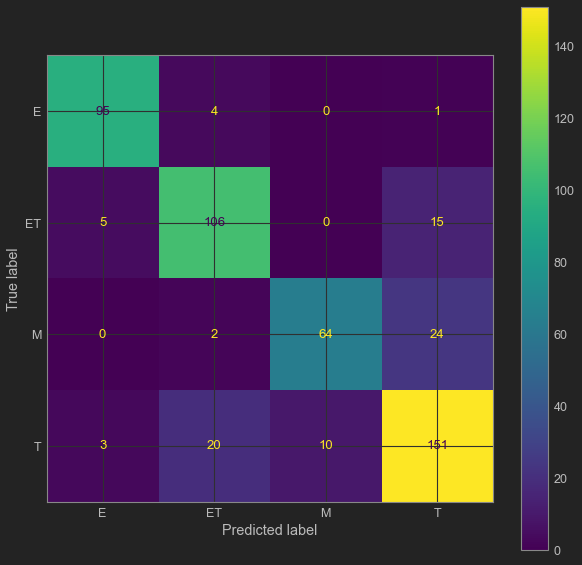

In [77]:
cm = confusion_matrix(y_exp_test, predictions)
display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=label_mapping.keys())
fig, ax = plt.subplots(figsize=(10,10))
display.plot(ax=ax)
print(classification_report(y_exp_test, predictions,target_names=label_mapping.keys(),digits=4))

<h5> Insights and conclusion

Out of the three models we chose to start with, the Decision Tree model seems to be the best at handling this case with an accuracy of 83.0%. With that, we experimented on different hyperparameters in an attempt to improve its accuracy. That experiment resulted in a Decision Tree model with an accuracy of 83.4%. Furthermore, we experimented with removing the top 5 least importance features. This resulted in a marginal improvement in accuracy, 83.8%.